In [103]:
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import pandas as pd
# 모든 행을 출력하도록 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 기본값으로 설정 (처음 5개와 마지막 5개 행만 출력)
pd.reset_option('display.max_rows')

# 출력 포맷 설정 (소수점 4자리까지)
pd.options.display.float_format = '{:.4f}'.format

import platform
import seaborn as sns

import matplotlib.pyplot as plt

# 운영 체제 확인
if platform.system() == 'Darwin':  # Mac
    print('apple gothic')
    font_name = 'AppleGothic'
elif platform.system() == 'Windows':  # Windows
    font_name = 'NanumGothic'
else:
    font_name = None

# 한글 폰트 설정
if font_name:
    plt.rcParams['font.family'] = font_name

# 마이너스 부호 설정
plt.rcParams['axes.unicode_minus'] = False

apple gothic


## 데이터로드

In [104]:
X_train = pd.read_csv('../data/dataset/X_train_scaled_std.csv', dtype={'거래소코드' : 'object'}).set_index('거래소코드')
X_test = pd.read_csv('../data/dataset/X_test_scaled_std.csv', dtype={'거래소코드' : 'object'}).set_index('거래소코드')

y_train = pd.read_csv('../data/dataset/y_train.csv', dtype={'거래소코드' : 'object'}).set_index('거래소코드')
y_test = pd.read_csv('../data/dataset/y_test.csv', dtype={'거래소코드' : 'object'}).set_index('거래소코드')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1187, 166), (198, 166), (1187, 1), (198, 1))

In [105]:
X_TRAIN = X_train.copy()
X_TEST = X_test.copy()

In [106]:
# standard + (ttest & wrapper & logit) : 28개

features = [
    '총자본정상영업이익률', '변동비대비매출액', '총자본순이익률', '자기자본순이익률', '매출액순이익률',
    '총자산회전율', '매출액', '매출채권 및 기타유동채권', '순운전자본(민식)', '매출채권',
    '변동비', '총비용', '비유동장기적합률', '미처분이익잉여금(결손금)', '유동자산',
    '비유동비율', '자기자본비율', '비유동부채비율', '매출액정상영업이익률', '당좌비율',
    '판매비와 관리비(물류원가 등 포함)', '영업손익', '자본금회전율', '연구개발비', '순운전자본대비총자본',
    '비유동자산', '자본', '배당금지급(-)'
]

len(features)

28

In [1]:
# 28개 중 vif, corr, pvalue 기준 11개

features = [
  # 재무제표 항목
  '미처분이익잉여금(결손금)', '배당금지급(-)',

   # 수익성
  '영업손익', '자기자본순이익률', '총자본정상영업이익률',

    # 안정성
  '당좌비율',  '순운전자본대비총자본', '비유동장기적합률',

  # 활동성
  '자본금회전율', '총자산회전율'
]

len(features)

10

In [109]:
# # 샤플리 - lr
# features =['총자본정상영업이익률', '총자본사업이익률', '변동비대비매출액', '총자본순이익률', '자기자본순이익률',
#        '차입금대비매출액', '총자산회전율', '인건비대비매출액', '매출채권 및 기타유동채권', '순운전자본(민식)',
#        '비유동장기적합률', '차입금의존도', '배당수익률', '자기자본비율', 'Core_CPI']
# len(features)

In [110]:
# # 샤플리 XGboost 
# features  = ['매출액', '총비용', '변동비', '매출채권', '매출채권 및 기타유동채권', '유동자산', '비유동자산',
#        '순운전자본(민식)', '판매비와 관리비(물류원가 등 포함)', '변동비대비매출액', '매출액순이익률', '비유동비율',
#        '비유동부채비율', '매출액정상영업이익률', '비유동장기적합률']

In [111]:
# # 샤플리 cat
# features = ['총자본사업이익률', '자본', '순운전자본대비총자본', '총자본정상영업이익률', '비유동자산', '인건비대비매출액',
#        '연구개발비', '차입금대비매출액', '배당금지급(-)', '자본금회전율', '당좌비율', '변동비대비매출액',
#        '매출채권 및 기타유동채권', '차입금의존도', '총자본순이익률']

In [112]:
X_train = X_TRAIN[features]
X_test = X_TEST[features]

In [113]:
X_train.describe()

,순운전자본대비총자본,비유동장기적합률,자기자본순이익률,당좌비율,총자본정상영업이익률,자본금회전율,총자산회전율,배당금지급(-),미처분이익잉여금(결손금),영업손익
count,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000
mean,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000
std,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004
min,-0.8600,-1.7937,-7.5136,-0.4050,-5.3785,-0.6959,-1.7269,-0.2343,-6.2114,-8.0748
25%,-0.8600,-0.6288,-0.0886,-0.3608,-0.3034,-0.5302,-0.6849,-0.2343,-0.1890,0.0525
50%,-0.3564,-0.1020,0.2688,-0.2970,0.3228,-0.3093,-0.1684,-0.2343,-0.1178,0.1386
75%,0.5855,0.3928,0.4286,-0.1218,0.6410,0.1002,0.5210,-0.1460,0.0188,0.1825
max,3.0945,5.0454,2.4009,6.8449,1.1852,5.6564,3.5447,8.3936,7.0966,6.5804


In [114]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def vif(data):

    # VIF 출력을 위한 데이터 프레임 형성
    vif = pd.DataFrame()

    # VIF 값과 각 Feature 이름에 대해 설정
    vif["VIF Factor"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    vif["features"] = data.columns 
                    
    # VIF 값이 높은 순으로 정렬
    vif = vif.sort_values(by="VIF Factor", ascending=False)
    vif = vif.reset_index().drop(columns='index')
    
    return vif

vifs = vif(X_train)
vifs

,VIF Factor,features
0,3.2780,순운전자본대비총자본
1,2.6956,비유동장기적합률
2,1.8472,자기자본순이익률
3,1.8377,당좌비율
4,1.5148,총자본정상영업이익률
5,1.3019,자본금회전율
6,1.2758,총자산회전율
7,1.2294,배당금지급(-)
8,1.1909,미처분이익잉여금(결손금)
9,1.1622,영업손익


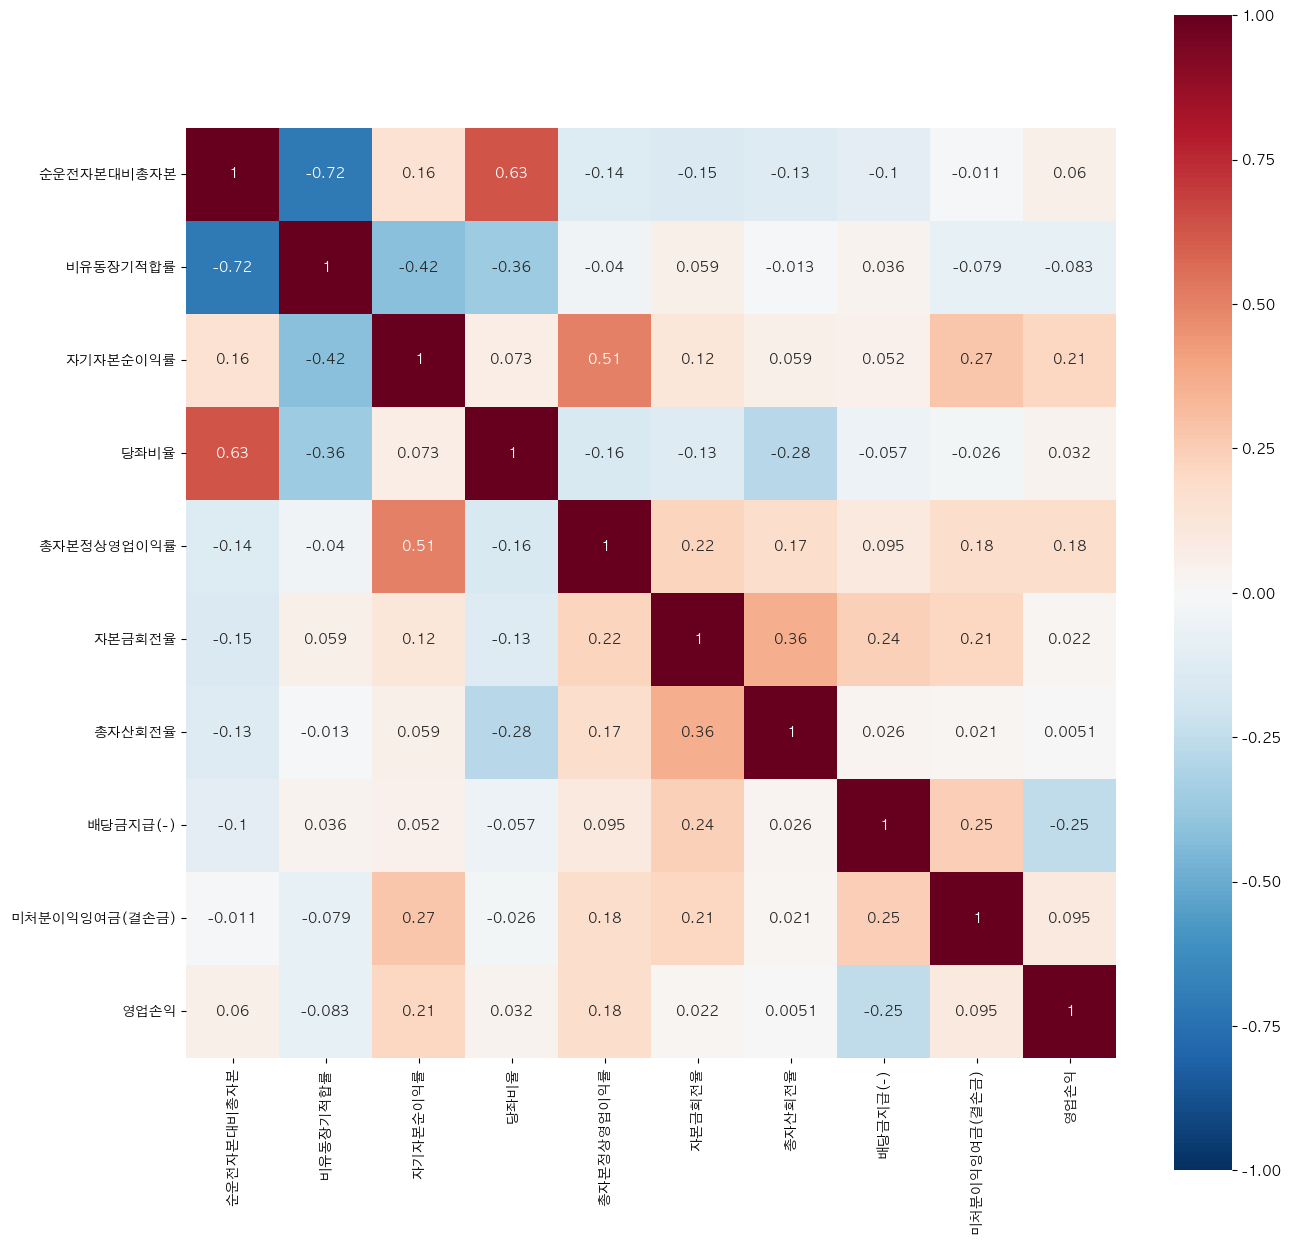

In [115]:
# vif 높은 순서대로 정렬
# 상관계수 히트맵
plt.figure(figsize=(15, 15))
sns.heatmap(
    X_train.corr(),
    annot = True,
    square = True,
    cmap='RdBu_r',
    vmin=-1, vmax=1
)
plt.show()

In [116]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1187, 10), (198, 10), (1187, 1), (198, 1))

In [118]:
## 파일로 저장

X_train.to_csv('../data/dataset_final/X_train.csv')
X_test.to_csv('../data/dataset_final/X_test.csv')
y_train.to_csv('../data/dataset_final/y_train.csv')
y_test.to_csv('../data/dataset_final/y_test.csv')

## 모델링

In [125]:
import modules.modeling as ml

# names = ['lr', 'dt', 'svm', 'rf', 'xgb', 'lgbm', 'cat']
names = ['lr', 'svm', 'dt', 'rf', 'lgbm', 'xgb', 'cat']
res = {}
for name in names:
    res[name] = ml.train(X_train, y_train, X_test, y_test, model_name=name)

[LightGBM] [Info] Number of positive: 409, number of negative: 778
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 1187, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.344566 -> initscore=-0.643011
[LightGBM] [Info] Start training from score -0.643011
[LightGBM] [Info] Number of positive: 327, number of negative: 622
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 949, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.344573 -> initscore=-0.642980
[LightGBM] [Info] Start training from score -0.642980
[LightGBM] [Info] Numbe

In [126]:
results, results_cv = [], []

for key in res.keys():
    res[key]['results']['name'] = key
    results.append(res[key]['results'])

    res_cv = dict(res[key]['cv'].drop(columns='cf_matrix').mean())
    res_cv['name'] = key
    results_cv.append(res_cv)

results = pd.DataFrame(results)
results_cv = pd.DataFrame(results_cv)

In [127]:
# vif + corr
X_train.shape, X_train.columns

((1187, 10),
 Index(['순운전자본대비총자본', '비유동장기적합률', '자기자본순이익률', '당좌비율', '총자본정상영업이익률', '자본금회전율',
        '총자산회전율', '배당금지급(-)', '미처분이익잉여금(결손금)', '영업손익'],
       dtype='object'))

In [128]:
X_test.describe()

,순운전자본대비총자본,비유동장기적합률,자기자본순이익률,당좌비율,총자본정상영업이익률,자본금회전율,총자산회전율,배당금지급(-),미처분이익잉여금(결손금),영업손익
count,198.0000,198.0000,198.0000,198.0000,198.0000,198.0000,198.0000,198.0000,198.0000,198.0000
mean,0.4830,-0.4332,0.0561,0.4662,-0.2340,1.2814,-0.4205,0.8208,0.3330,-0.0711
std,1.1263,0.6515,0.9784,2.0428,1.3303,14.8035,0.8841,8.2873,4.3393,1.1909
min,-0.8600,-1.7855,-10.2863,-0.3942,-8.6945,-0.6946,-1.7435,-0.2343,-2.4463,-11.8181
25%,-0.4133,-0.8937,-0.0264,-0.3136,-0.6872,-0.5270,-1.0913,-0.2343,-0.2153,-0.0136
50%,0.2764,-0.4717,0.2684,-0.1917,0.2790,-0.2229,-0.5133,-0.1887,-0.1039,0.1188
75%,1.1282,-0.0652,0.4242,0.2574,0.6100,0.5194,0.0851,-0.0157,0.1558,0.1777
max,3.7301,1.8922,1.6605,18.0444,1.0102,207.6497,3.1064,112.3313,59.7194,2.8690


In [137]:
# 교차검정 결과
results_cv = results_cv.set_index('name')
results_cv

KeyError: "None of ['name'] are in the columns"

In [138]:
""" standard scaling"""
# test 결과
results_test = results.set_index('name')
results_test

,cf_matrix,accuracy,precision,recall,f1,roc_auc
name,,,,,,
lr,"[[117, 7], [62, 12]]",0.6515,0.6316,0.1622,0.2581,0.7005
svm,"[[122, 2], [69, 5]]",0.6414,0.7143,0.0676,0.1235,0.6533
dt,"[[84, 40], [38, 36]]",0.6061,0.4737,0.4865,0.4800,0.5820
rf,"[[104, 20], [54, 20]]",0.6263,0.5000,0.2703,0.3509,0.6461
lgbm,"[[99, 25], [48, 26]]",0.6313,0.5098,0.3514,0.4160,0.6440
xgb,"[[93, 31], [44, 30]]",0.6212,0.4918,0.4054,0.4444,0.6381
cat,"[[107, 17], [50, 24]]",0.6616,0.5854,0.3243,0.4174,0.6724


In [139]:
pd.merge(
    results_cv, results_test.drop(columns='cf_matrix'),
    left_index=True, right_index=True,
    suffixes=('_train', '_test')
)

,accuracy_train,precision_train,recall_train,f1_train,roc_auc_train,accuracy_test,precision_test,recall_test,f1_test,roc_auc_test
name,,,,,,,,,,
lr,0.6672,0.5696,0.2127,0.3028,0.6776,0.6515,0.6316,0.1622,0.2581,0.7005
svm,0.6554,0.5132,0.0953,0.1542,0.6198,0.6414,0.7143,0.0676,0.1235,0.6533
dt,0.5763,0.3816,0.3714,0.3744,0.5277,0.6061,0.4737,0.4865,0.4800,0.5820
rf,0.6513,0.4981,0.2982,0.3671,0.6455,0.6263,0.5000,0.2703,0.3509,0.6461
lgbm,0.6361,0.4694,0.3421,0.3872,0.6351,0.6313,0.5098,0.3514,0.4160,0.6440
xgb,0.6369,0.4707,0.3641,0.4052,0.6291,0.6212,0.4918,0.4054,0.4444,0.6381
cat,0.6622,0.5320,0.3055,0.3753,0.6504,0.6616,0.5854,0.3243,0.4174,0.6724


In [22]:
X_train.shape, X_train.columns

((1187, 10),
 Index(['순운전자본대비총자본', '비유동장기적합률', '자기자본순이익률', '당좌비율', '총자본정상영업이익률', '자본금회전율',
        '총자산회전율', '배당금지급(-)', '미처분이익잉여금(결손금)', '영업손익'],
       dtype='object'))

In [24]:
X_train.describe()

,순운전자본대비총자본,비유동장기적합률,자기자본순이익률,당좌비율,총자본정상영업이익률,자본금회전율,총자산회전율,배당금지급(-),미처분이익잉여금(결손금),영업손익
count,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000,1187.0000
mean,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000
std,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004,1.0004
min,-0.8600,-1.7937,-7.5136,-0.4050,-5.3785,-0.6959,-1.7269,-0.2343,-6.2114,-8.0748
25%,-0.8600,-0.6288,-0.0886,-0.3608,-0.3034,-0.5302,-0.6849,-0.2343,-0.1890,0.0525
50%,-0.3564,-0.1020,0.2688,-0.2970,0.3228,-0.3093,-0.1684,-0.2343,-0.1178,0.1386
75%,0.5855,0.3928,0.4286,-0.1218,0.6410,0.1002,0.5210,-0.1460,0.0188,0.1825
max,3.0945,5.0454,2.4009,6.8449,1.1852,5.6564,3.5447,8.3936,7.0966,6.5804


### 최종 모델 선택

In [102]:
# test
results.set_index('name')

,cf_matrix,accuracy,precision,recall,f1,roc_auc
name,,,,,,
lr,"[[117, 7], [62, 12]]",0.6515,0.6316,0.1622,0.2581,0.7005
dt,"[[84, 40], [38, 36]]",0.6061,0.4737,0.4865,0.4800,0.5820
svm,"[[122, 2], [69, 5]]",0.6414,0.7143,0.0676,0.1235,0.6533
rf,"[[104, 20], [54, 20]]",0.6263,0.5000,0.2703,0.3509,0.6461
xgb,"[[93, 31], [44, 30]]",0.6212,0.4918,0.4054,0.4444,0.6381
lgbm,"[[99, 25], [48, 26]]",0.6313,0.5098,0.3514,0.4160,0.6440
cat,"[[107, 17], [50, 24]]",0.6616,0.5854,0.3243,0.4174,0.6724


In [143]:
results.sort_values('precision', ascending=False)

,cf_matrix,accuracy,precision,recall,f1,roc_auc,name
1,"[[122, 2], [69, 5]]",0.6414,0.7143,0.0676,0.1235,0.6533,svm
0,"[[117, 7], [62, 12]]",0.6515,0.6316,0.1622,0.2581,0.7005,lr
6,"[[107, 17], [50, 24]]",0.6616,0.5854,0.3243,0.4174,0.6724,cat
4,"[[99, 25], [48, 26]]",0.6313,0.5098,0.3514,0.4160,0.6440,lgbm
3,"[[104, 20], [54, 20]]",0.6263,0.5000,0.2703,0.3509,0.6461,rf
5,"[[93, 31], [44, 30]]",0.6212,0.4918,0.4054,0.4444,0.6381,xgb
2,"[[84, 40], [38, 36]]",0.6061,0.4737,0.4865,0.4800,0.5820,dt


In [144]:
results.sort_values('f1', ascending=False)

,cf_matrix,accuracy,precision,recall,f1,roc_auc,name
2,"[[84, 40], [38, 36]]",0.6061,0.4737,0.4865,0.4800,0.5820,dt
5,"[[93, 31], [44, 30]]",0.6212,0.4918,0.4054,0.4444,0.6381,xgb
6,"[[107, 17], [50, 24]]",0.6616,0.5854,0.3243,0.4174,0.6724,cat
4,"[[99, 25], [48, 26]]",0.6313,0.5098,0.3514,0.4160,0.6440,lgbm
3,"[[104, 20], [54, 20]]",0.6263,0.5000,0.2703,0.3509,0.6461,rf
0,"[[117, 7], [62, 12]]",0.6515,0.6316,0.1622,0.2581,0.7005,lr
1,"[[122, 2], [69, 5]]",0.6414,0.7143,0.0676,0.1235,0.6533,svm


In [88]:
# train
results_cv = results_cv.set_index('name')
results_cv

,accuracy,precision,recall,f1,roc_auc
name,,,,,
lr,0.6672,0.5696,0.2127,0.3028,0.6776
dt,0.5763,0.3816,0.3714,0.3744,0.5277
svm,0.6554,0.5132,0.0953,0.1542,0.6198
rf,0.6513,0.4981,0.2982,0.3671,0.6455
xgb,0.6369,0.4707,0.3641,0.4052,0.6291
lgbm,0.6361,0.4694,0.3421,0.3872,0.6351
cat,0.6622,0.5320,0.3055,0.3753,0.6504


In [141]:
best_prec_method = results_cv.sort_values('precision', ascending=False).index[0]
print(best_prec_method)

results_cv.sort_values('precision', ascending=False)

lr


,accuracy,precision,recall,f1,roc_auc
name,,,,,
lr,0.6672,0.5696,0.2127,0.3028,0.6776
cat,0.6622,0.5320,0.3055,0.3753,0.6504
svm,0.6554,0.5132,0.0953,0.1542,0.6198
rf,0.6513,0.4981,0.2982,0.3671,0.6455
xgb,0.6369,0.4707,0.3641,0.4052,0.6291
lgbm,0.6361,0.4694,0.3421,0.3872,0.6351
dt,0.5763,0.3816,0.3714,0.3744,0.5277


In [94]:
best_f1_method = results_cv.sort_values('f1', ascending=False).index[0]
print(best_f1_method)

results_cv.sort_values('f1', ascending=False)

xgb


,accuracy,precision,recall,f1,roc_auc
name,,,,,
xgb,0.6369,0.4707,0.3641,0.4052,0.6291
lgbm,0.6361,0.4694,0.3421,0.3872,0.6351
cat,0.6622,0.5320,0.3055,0.3753,0.6504
dt,0.5763,0.3816,0.3714,0.3744,0.5277
rf,0.6513,0.4981,0.2982,0.3671,0.6455
lr,0.6672,0.5696,0.2127,0.3028,0.6776
svm,0.6554,0.5132,0.0953,0.1542,0.6198


In [36]:
# train, test 결합

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
X.shape, y.shape, X.index.equals(y.index)

((1385, 10), (1385, 1), True)

In [145]:
info = pd.read_csv('../data/6_데이터셋_불필요컬럼제거.csv', dtype={'거래소코드':'object'})[['회사명', '거래소코드', '회계년도', 'label']].set_index('거래소코드')

info.head()

,회사명,회계년도,label
거래소코드,,,
000040,케이알모터스(주),2012/12,0.0000
000050,(주)경방,2012/12,1.0000
000070,(주)삼양홀딩스,2013/12,1.0000
000150,(주)두산,2015/12,1.0000
000180,성창기업지주(주),2012/12,0.0000


In [147]:
info.to_csv('../../quant/dataset/dataset_m1.csv')

In [ ]:
fname='m1_2019_2021'

In [149]:
from pykrx import stock

best_methods = {'f1' : best_f1_method, 'prec' : best_prec_method}
best_models = {key: res[method]['model'] for key, method in best_methods.items()}

# 포트폴리오 생성
best_portfolios = {}
dname = '../../quant/portfolios'
for key, model in best_models.items():
    pf = y.copy()
    
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]
    
    pf['pred'] = y_pred
    pf['proba1'] = y_pred_proba

    pf = pd.merge(
        pf, info[['회사명', '회계년도']],
        left_index=True, right_index=True,
        how='left'
    )

    best_portfolios[key] = pf

    # 파일로 저장
    pf.to_csv(dname+'/'+fname+'_'+key+'_'+ best_methods[key] +'.csv')

best_rtns = {}
dname = '../../quant/rtns'
for key, pf in best_portfolios.items():
    print(key)
    
    # 1로 예측된 기업만 투자
    pf = pf[pf['pred']==1]
    pf['year'] = pd.to_datetime(pf['회계년도']).dt.year
    
    rtn = []
    for year in pf['year'].unique():
        tickers = pf[pf['year']==year].index

        print(f'{year}년, 투자종목수:{len(tickers)}')

        df_price = pd.DataFrame()

        # 개별 종목 종가 로드 및 결합
        for ticker in tickers:
            price = stock.get_market_ohlcv(f'{year+1}0401', f'{year+2}0331', ticker)[['종가']]
            price.rename(columns = {'종가' : ticker}, inplace=True)

            # index : datetime
            df_price = pd.merge(
                df_price, price,
                left_index=True, right_index=True,
                how='outer'
            )

        # 포트폴리오 종가 계산
        df_price['sum'] = df_price.sum(axis=1)
        try:
            df_price['수익률'] = df_price['sum'].pct_change().fillna(0)
            df_price['year'] = year
            rtn.append(df_price[['year', 'sum', '수익률']])
        except:
            print(f'{year}년도는 투자 X')
            continue

    rtn = pd.concat(rtn, axis=0)
    rtn = rtn.sort_index()
    best_rtns[key] = rtn

    # 파일로 저장
    rtn.to_csv(dname+'/'+fname+'_'+key+'_'+ best_methods[key] +'.csv')


f1
2012년, 투자종목수:123
2013년, 투자종목수:54
2015년, 투자종목수:38
2017년, 투자종목수:27
2019년, 투자종목수:27
2014년, 투자종목수:49
2018년, 투자종목수:34
2016년, 투자종목수:16
2021년, 투자종목수:17
2020년, 투자종목수:35
prec
2015년, 투자종목수:14
2013년, 투자종목수:21
2018년, 투자종목수:9
2019년, 투자종목수:9
2014년, 투자종목수:18
2012년, 투자종목수:46
2017년, 투자종목수:9
2016년, 투자종목수:2
2020년, 투자종목수:10
2021년, 투자종목수:6


In [83]:
best_rtns['f1']

,year,sum,수익률
날짜,,,
2013-04-01,2012,892035,0.0000
2013-04-02,2012,884250,-0.0087
2013-04-03,2012,893091,0.0100
2013-04-04,2012,892998,-0.0001
2013-04-05,2012,891797,-0.0013
...,...,...,...
2023-03-27,2021,198450,0.1039
2023-03-28,2021,203045,0.0232
2023-03-29,2021,199055,-0.0197


In [84]:
best_rtns['prec']

,year,sum,수익률
날짜,,,
2013-04-01,2012,441469,0.0000
2013-04-02,2012,431109,-0.0235
2013-04-03,2012,429027,-0.0048
2013-04-04,2012,423524,-0.0128
2013-04-05,2012,416579,-0.0164
...,...,...,...
2023-03-27,2021,27270,-0.0011
2023-03-28,2021,27480,0.0077
2023-03-29,2021,27590,0.0040


In [68]:
best_portfolio['f1'].head()

,label,pred,proba1,회사명,회계년도
거래소코드,,,,,
000040,0.0000,0,0.0243,케이알모터스(주),2012/12
000050,1.0000,1,0.9215,(주)경방,2012/12
000070,1.0000,1,0.9650,(주)삼양홀딩스,2013/12
000150,1.0000,1,0.9679,(주)두산,2015/12
000180,0.0000,0,0.0745,성창기업지주(주),2012/12


In [71]:
pf = best_portfolio['f1']

pf[pf['pred']==1].pivot_table(
    index='회계년도',
    columns = 'label',
    values = 'pred',
    aggfunc=len
)

label,0.0000,1.0000
회계년도,,
2012/12,2,121
2013/12,1,53
2014/12,4,45
2015/12,3,35
2016/12,2,14
2017/12,2,25
2018/12,2,32
2019/12,3,24
2020/12,15,20


In [69]:
best_portfolio['prec'].head()

,label,pred,proba1,회사명,회계년도
거래소코드,,,,,
000040,0.0000,0.0000,0.3319,케이알모터스(주),2012/12
000050,1.0000,0.0000,0.2505,(주)경방,2012/12
000070,1.0000,0.0000,0.4297,(주)삼양홀딩스,2013/12
000150,1.0000,1.0000,0.7611,(주)두산,2015/12
000180,0.0000,0.0000,0.4600,성창기업지주(주),2012/12


In [73]:
pf = best_portfolio['prec']

pf[pf['pred']==1].pivot_table(
    index='회계년도',
    columns = 'label',
    values = 'pred',
    aggfunc=len,
    
).fillna(0)

label,0.0000,1.0000
회계년도,,
2012/12,25.0000,21.0000
2013/12,11.0000,10.0000
2014/12,7.0000,11.0000
2015/12,3.0000,11.0000
2016/12,0.0000,2.0000
2017/12,4.0000,5.0000
2018/12,1.0000,8.0000
2019/12,4.0000,5.0000
2020/12,3.0000,7.0000


In [ ]:
# 수익률 계산

## 포트폴리오 생성

In [17]:
# 학습된 모델
res['lr']['model'].score(X_train, y_train)

0.6731255265374895

In [18]:
res['lr']['model'].score(X_test, y_test)

0.6161616161616161

## 피처 임포턴스 확인

In [19]:
model = res['rf']['model']

model

RandomForestClassifier(random_state=42)

In [20]:
model.feature_names_in_

array(['변동비대비매출액', '총자산회전율', '인건비대비매출액', '매출액', '매출채권 및 기타유동채권',
       '순운전자본(민식)', '매출채권', '변동비', '총비용', '비유동장기적합률', '고정비',
       '미처분이익잉여금(결손금)', '유동자산', '비유동비율', '자기자본비율', '비유동부채비율', '당좌비율',
       '급여', '영업손익', '자본금회전율', '연구개발비', 'manuf_GB', '유형자산', '비유동자산', '자본',
       '배당금지급(-)'], dtype=object)

In [21]:
def view_importance(model, method, features_final=None):
    try:
        # 중요도를 얻기
        feature_importance = model.feature_importances_
    except:
        print(f"{method}는 feature importance 못함")
        return False, method
    
    # 피처 리스트 추출
    if features_final is None:
        features_final = model.feature_names_in_

    # 중요도에 따라 변수들의 인덱스를 내림차순으로 정렬
    sorted_idx = feature_importance.argsort()[::-1]

    # 정렬된 변수의 중요도 및 변수명 출력
    # for i, idx in enumerate(sorted_idx):
    #     print(f"{features_final[idx]}: {feature_importance[idx]}")

    # 중요도를 막대 그래프로 시각화
    plt.figure(figsize= (10,8))
    plt.bar([f"{features_final[idx]}" for idx in sorted_idx], feature_importance[sorted_idx])
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Feature Importance (Sorted)')
    plt.xticks(rotation=45, ha='right')  # X 축 라벨을 45도 기울임
    plt.tight_layout()  # 레이아웃 조정
    plt.title(method)
    plt.show()

    return True, pd.DataFrame(feature_importance, index = features_final, columns = [method])


lr는 feature importance 못함


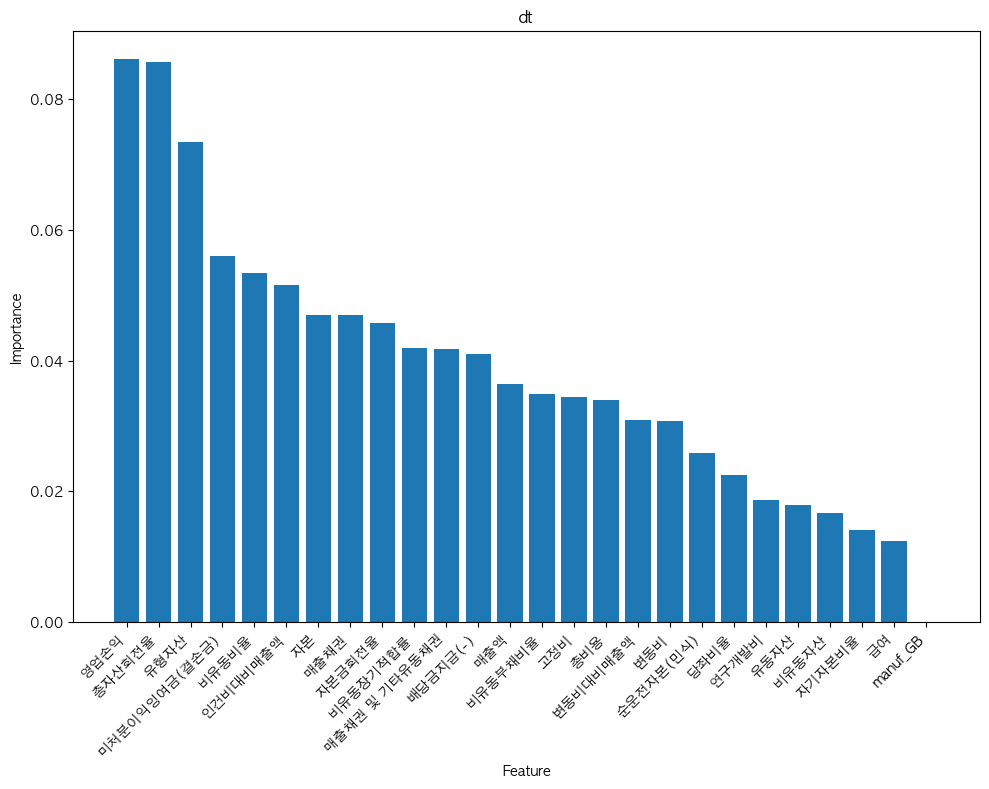

svm는 feature importance 못함


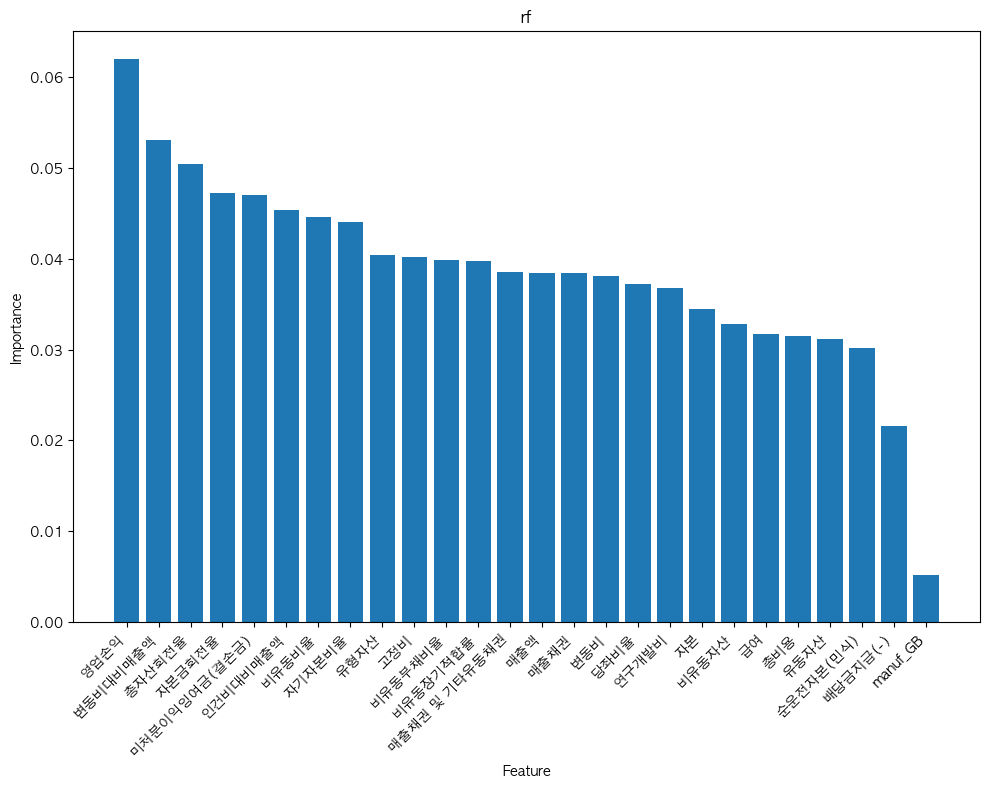

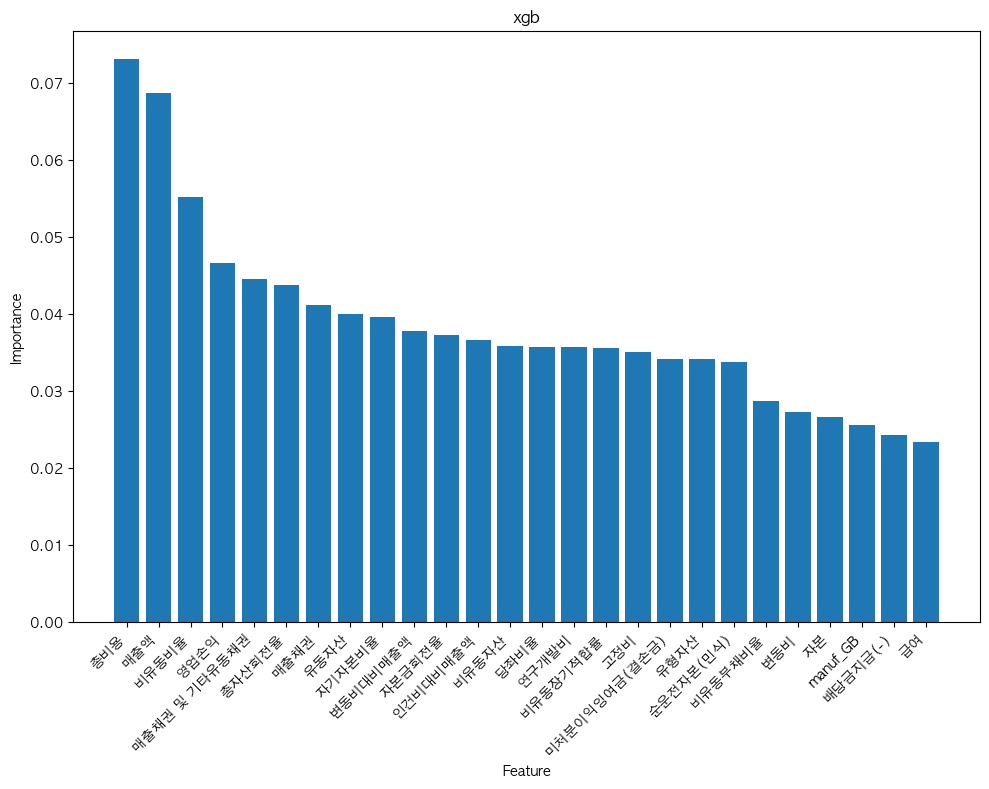

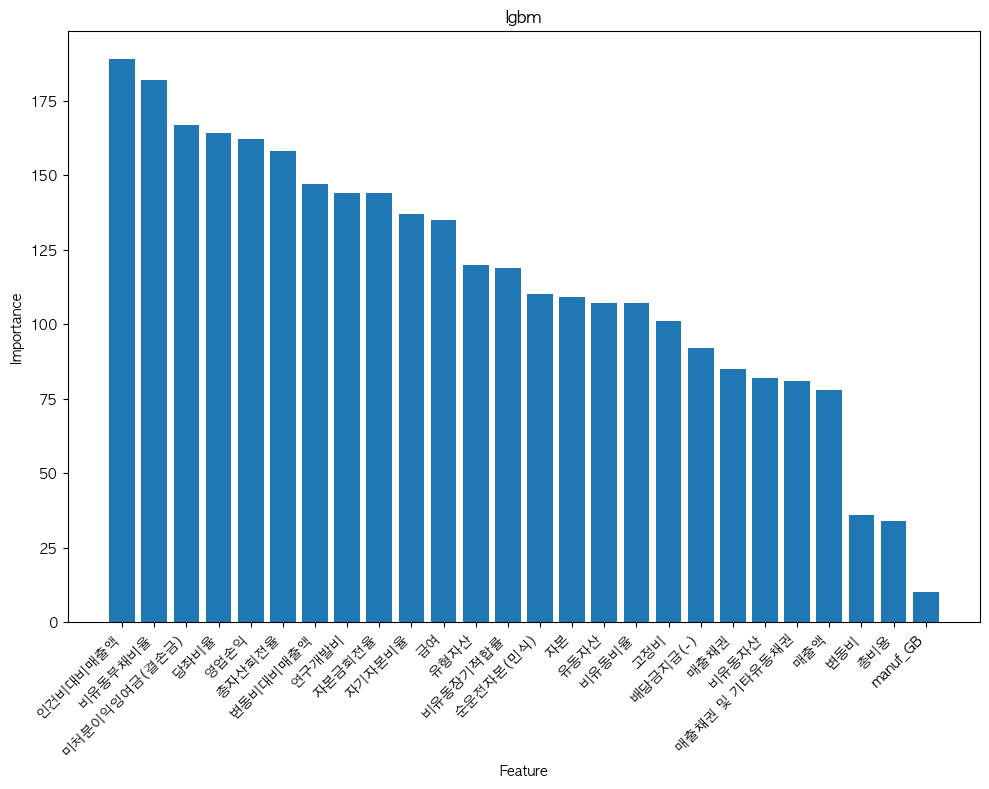

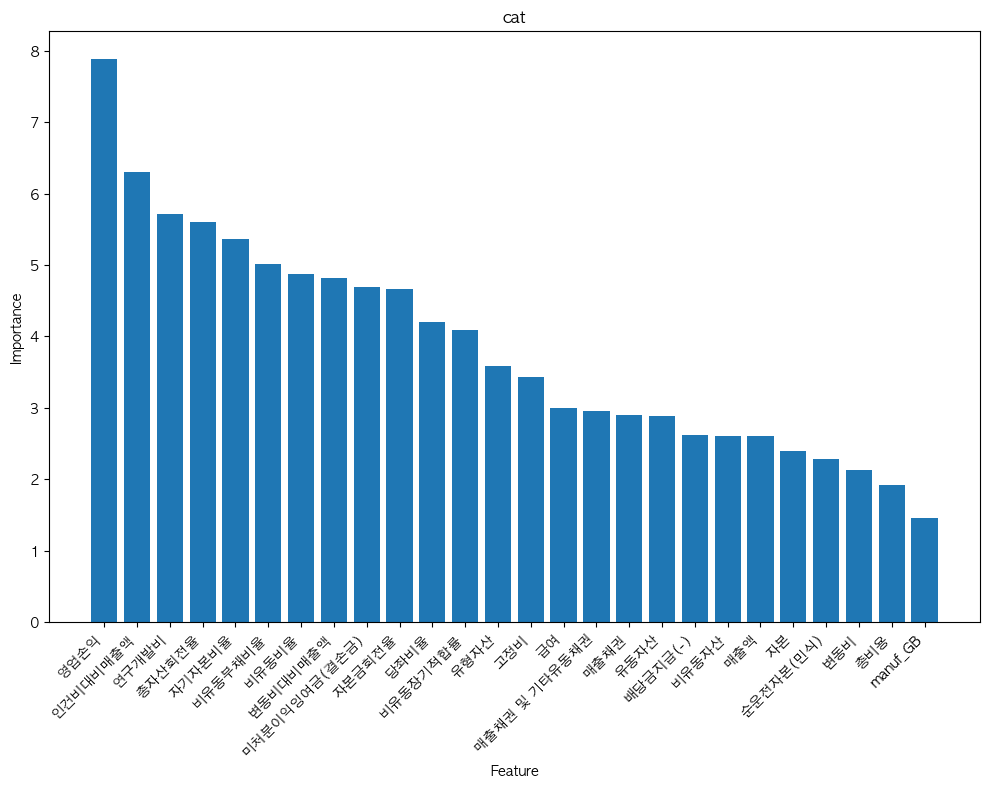

,dt,rf,xgb,lgbm,cat
변동비대비매출액,0.0309,0.0530,0.0378,147,4.8201
총자산회전율,0.0856,0.0504,0.0438,158,5.6049
인건비대비매출액,0.0516,0.0454,0.0367,189,6.2997
매출액,0.0364,0.0384,0.0687,78,2.6095
매출채권 및 기타유동채권,0.0418,0.0385,0.0445,81,2.9587
순운전자본(민식),0.0259,0.0302,0.0337,110,2.2898
매출채권,0.0469,0.0384,0.0412,85,2.8982
변동비,0.0308,0.0381,0.0273,36,2.1282
총비용,0.0340,0.0315,0.0731,34,1.9146
비유동장기적합률,0.0420,0.0398,0.0356,119,4.0912


In [22]:
importances = pd.DataFrame([], index = X_train.columns)
for key in res.keys():
    model = res[key]['model']
    stat, res_imp = view_importance(model, key, features_final=X_train.columns)
    if stat:
        importances = pd.merge(
            importances, res_imp,
            left_index=True, right_index=True,
            how='outer'
        )

importances

In [23]:
# 비율로 변경

importances['lgbm'] /= sum(importances['lgbm'])
importances['cat'] /= sum(importances['cat'])
importances

,dt,rf,xgb,lgbm,cat
변동비대비매출액,0.0309,0.0530,0.0378,0.0490,0.0482
총자산회전율,0.0856,0.0504,0.0438,0.0527,0.0560
인건비대비매출액,0.0516,0.0454,0.0367,0.0630,0.0630
매출액,0.0364,0.0384,0.0687,0.0260,0.0261
매출채권 및 기타유동채권,0.0418,0.0385,0.0445,0.0270,0.0296
순운전자본(민식),0.0259,0.0302,0.0337,0.0367,0.0229
매출채권,0.0469,0.0384,0.0412,0.0283,0.0290
변동비,0.0308,0.0381,0.0273,0.0120,0.0213
총비용,0.0340,0.0315,0.0731,0.0113,0.0191
비유동장기적합률,0.0420,0.0398,0.0356,0.0397,0.0409


In [24]:
importances.sum()

dt     1.0000
rf     1.0000
xgb    1.0000
lgbm   1.0000
cat    1.0000
dtype: float64

In [25]:
importances.sum(axis=1)

변동비대비매출액        0.2189
총자산회전율          0.2885
인건비대비매출액        0.2597
매출액             0.1956
매출채권 및 기타유동채권   0.1814
순운전자본(민식)       0.1493
매출채권            0.1838
변동비             0.1295
총비용             0.1690
비유동장기적합률        0.1979
고정비             0.1777
미처분이익잉여금(결손금)   0.2395
유동자산            0.1536
비유동비율           0.2376
자기자본비율          0.1970
비유동부채비율         0.2142
당좌비율            0.1922
급여              0.1426
영업손익            0.3275
자본금회전율          0.2248
연구개발비           0.1963
manuf_GB        0.0487
유형자산            0.2236
비유동자산           0.1389
자본              0.1683
배당금지급(-)        0.1438
dtype: float64

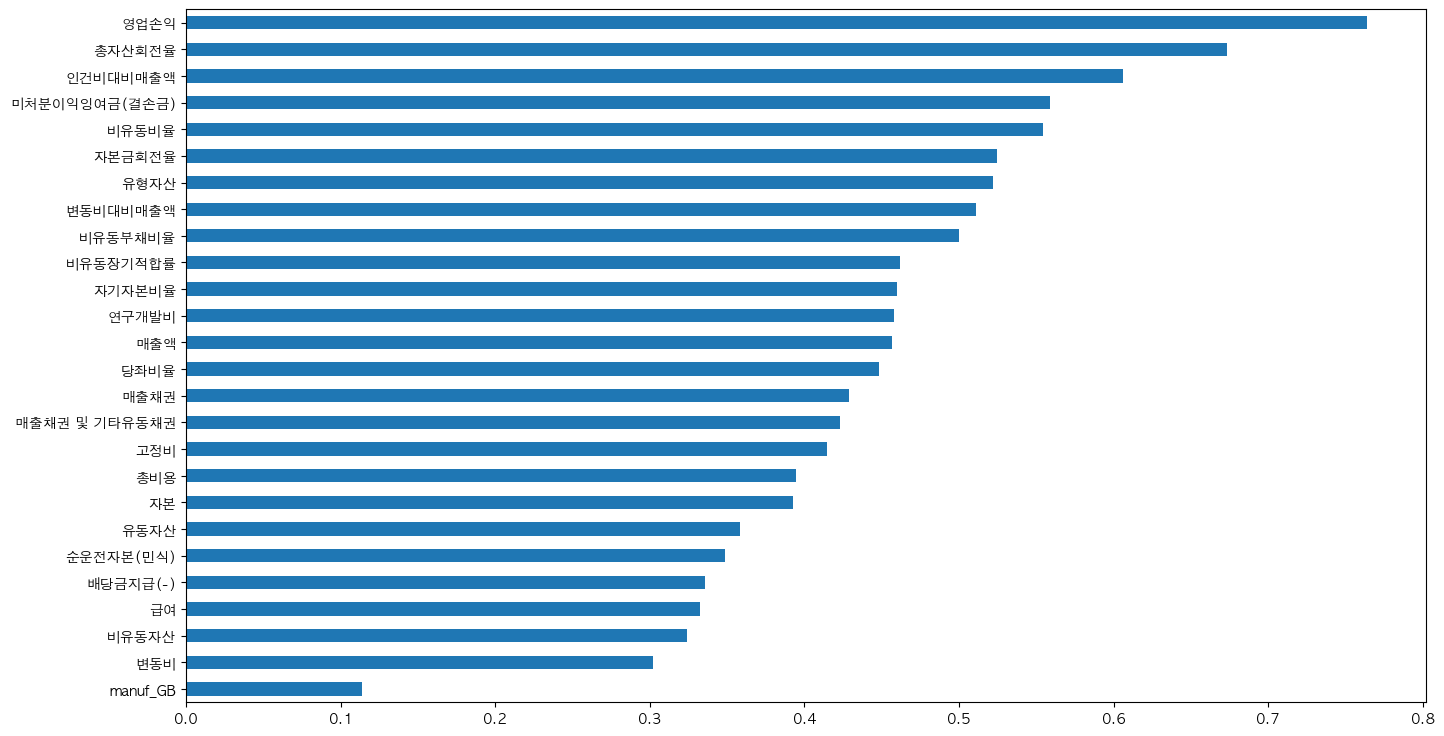

In [81]:
importances['합'] = importances.sum(axis=1)

plt.figure(figsize=(16, 9))
importances['합'].sort_values().plot(kind='barh')
plt.show()

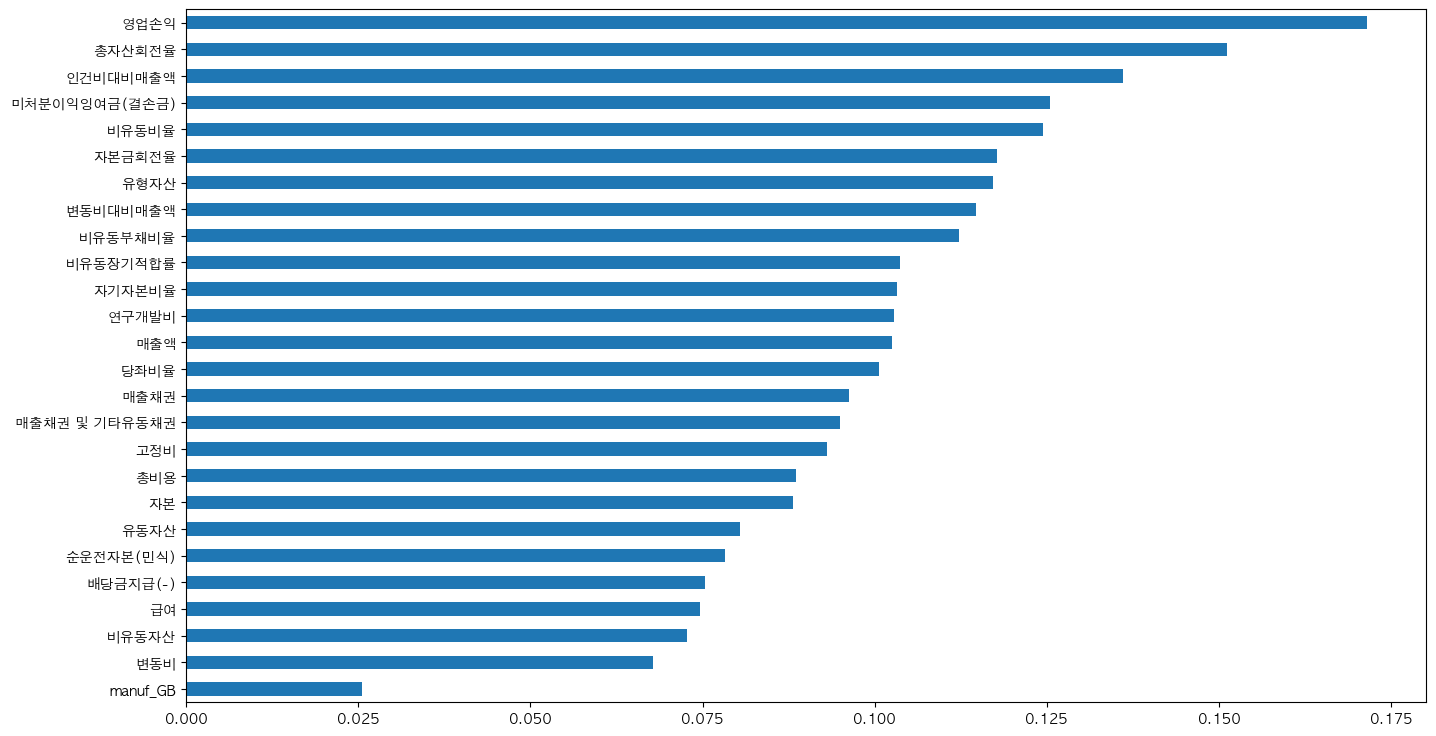

In [82]:
importances['평균'] = importances.mean(axis=1)

plt.figure(figsize=(16, 9))
importances['평균'].sort_values().plot(kind='barh')
plt.show()

In [94]:
importances.sort_values(by=['평균'], ascending=False).reset_index()

,index,dt,rf,xgb,lgbm,cat,합,평균
0,영업손익,0.0861,0.0620,0.0465,0.0540,0.0788,0.7641,0.1715
1,총자산회전율,0.0856,0.0504,0.0438,0.0527,0.0560,0.6731,0.1511
2,인건비대비매출액,0.0516,0.0454,0.0367,0.0630,0.0630,0.6059,0.1360
3,미처분이익잉여금(결손금),0.0559,0.0470,0.0341,0.0557,0.0469,0.5589,0.1255
4,비유동비율,0.0534,0.0446,0.0552,0.0357,0.0487,0.5544,0.1245
5,자본금회전율,0.0458,0.0472,0.0372,0.0480,0.0466,0.5246,0.1178
6,유형자산,0.0733,0.0404,0.0341,0.0400,0.0358,0.5218,0.1171
7,변동비대비매출액,0.0309,0.0530,0.0378,0.0490,0.0482,0.5108,0.1147
8,비유동부채비율,0.0349,0.0398,0.0287,0.0607,0.0502,0.4998,0.1122
9,비유동장기적합률,0.0420,0.0398,0.0356,0.0397,0.0409,0.4618,0.1037


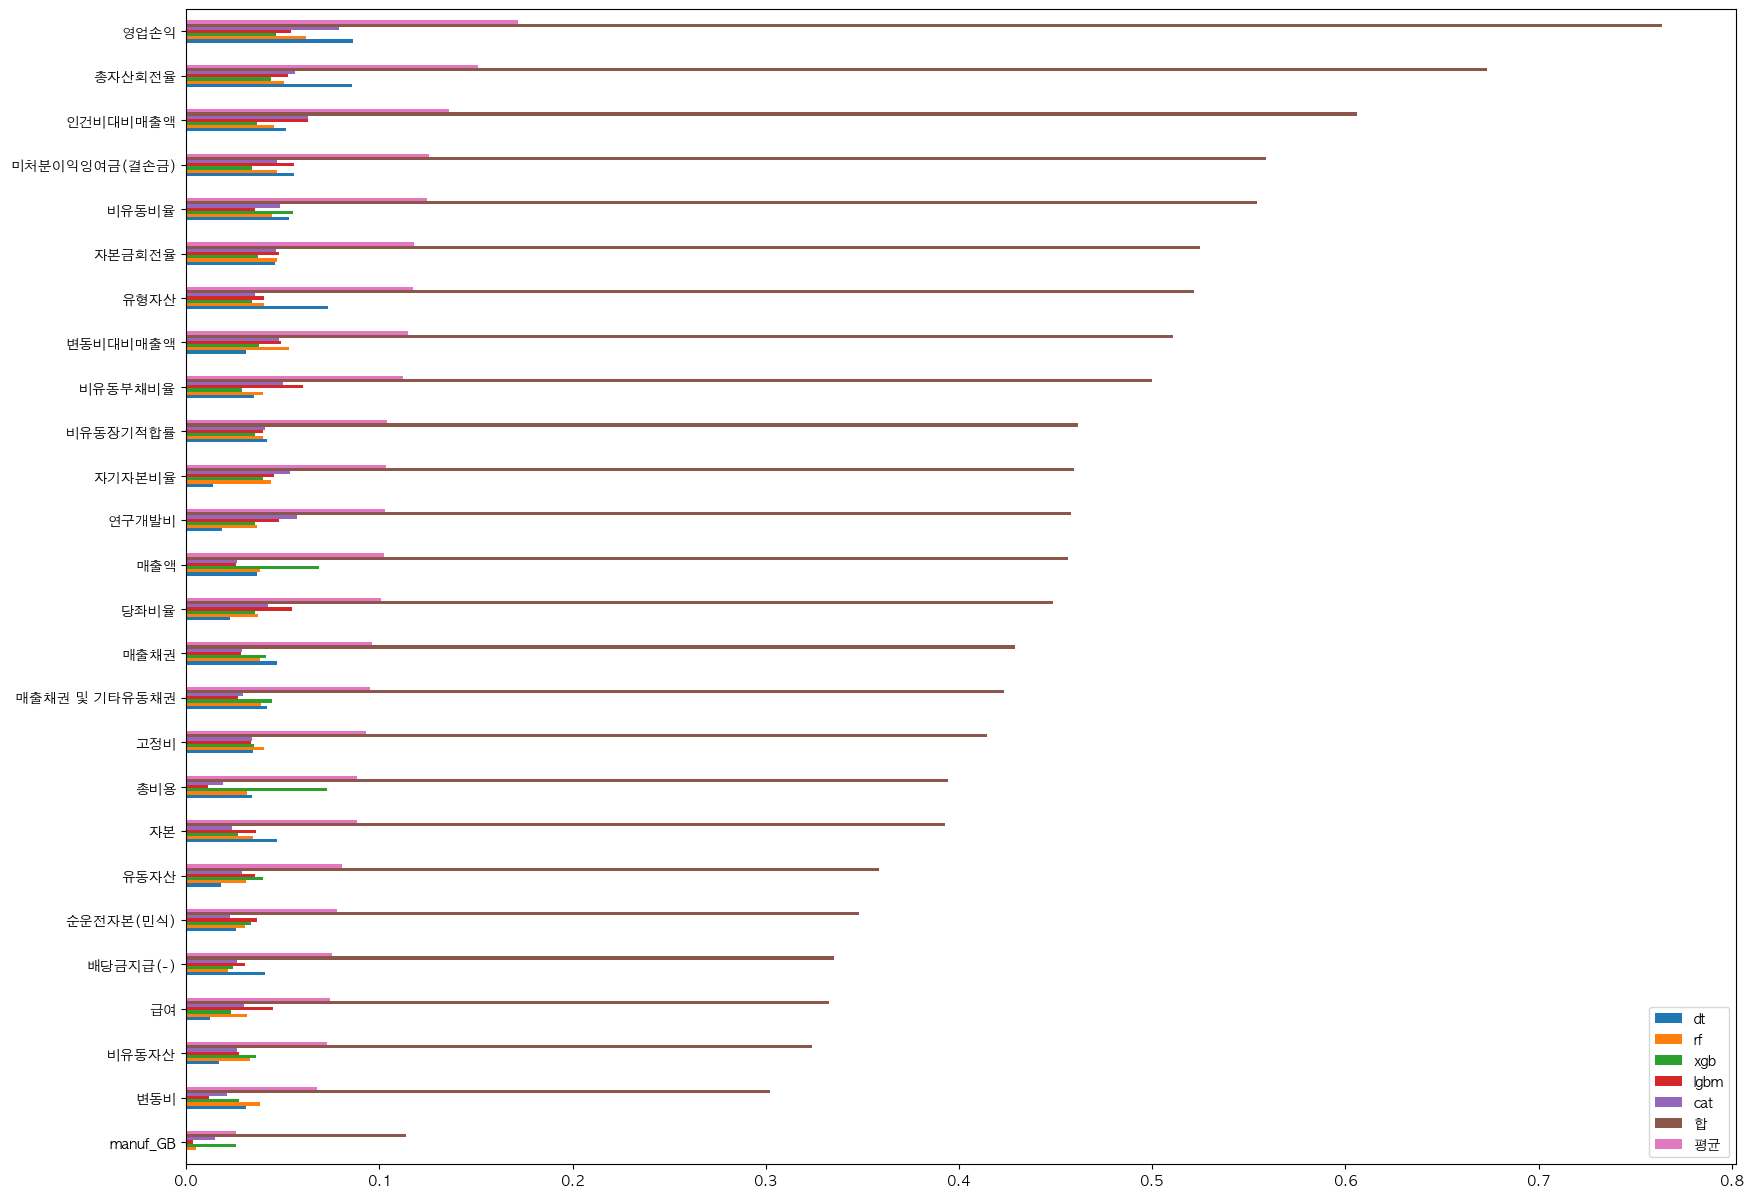

In [85]:
# plt.figure(figsize=(20, 9))
importances.sort_values(by=['합', '평균']).plot(kind='barh', figsize=(20, 15))
plt.show()

## threshold 조정

In [90]:
mname = 'rf'

model = res[mname]['model']

In [91]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

res_pred = pd.DataFrame(y_pred_proba, columns=['proba_0', 'proba_1'])

res_pred['y_pred'] = y_pred
res_pred['y_test'] = y_test['label'].values

res_pred

,proba_0,proba_1,y_pred,y_test
0,0.4900,0.5100,1.0000,0.0000
1,0.8100,0.1900,0.0000,1.0000
2,0.2400,0.7600,1.0000,1.0000
3,0.1900,0.8100,1.0000,0.0000
4,0.5100,0.4900,0.0000,0.0000
...,...,...,...,...
193,0.7100,0.2900,0.0000,0.0000
194,0.8100,0.1900,0.0000,0.0000
195,0.7200,0.2800,0.0000,1.0000
196,0.5500,0.4500,0.0000,0.0000


In [92]:
test = []

for thr in np.arange(0.1, 1, 0.1):
    # 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9

    y_pred_thr = (res_pred['proba_1']>thr).apply(int)

    eval_test = ml.eval(
        y_test['label'].values,
        y_pred_thr, 
        # y_pred, 
        y_pred_proba[:, 1], 
        # threshold = 0.5, print=False
    )
    eval_test['threshold'] = thr
    test.append(eval_test)

pd.DataFrame(test)

,cf_matrix,accuracy,precision,recall,f1,roc_auc,threshold
0,"[[2, 122], [0, 74]]",0.3838,0.3776,1.0000,0.5481,0.6232,0.1000
1,"[[18, 106], [5, 69]]",0.4394,0.3943,0.9324,0.5542,0.6232,0.2000
2,"[[59, 65], [23, 51]]",0.5556,0.4397,0.6892,0.5368,0.6232,0.3000
3,"[[91, 33], [44, 30]]",0.6111,0.4762,0.4054,0.4380,0.6232,0.4000
4,"[[109, 15], [57, 17]]",0.6364,0.5312,0.2297,0.3208,0.6232,0.5000
5,"[[121, 3], [66, 8]]",0.6515,0.7273,0.1081,0.1882,0.6232,0.6000
6,"[[123, 1], [71, 3]]",0.6364,0.7500,0.0405,0.0769,0.6232,0.7000
7,"[[123, 1], [74, 0]]",0.6212,0.0000,0.0000,0.0000,0.6232,0.8000
8,"[[124, 0], [74, 0]]",0.6263,0.0000,0.0000,0.0000,0.6232,0.9000


ROC AUC: 0.6232018308631211


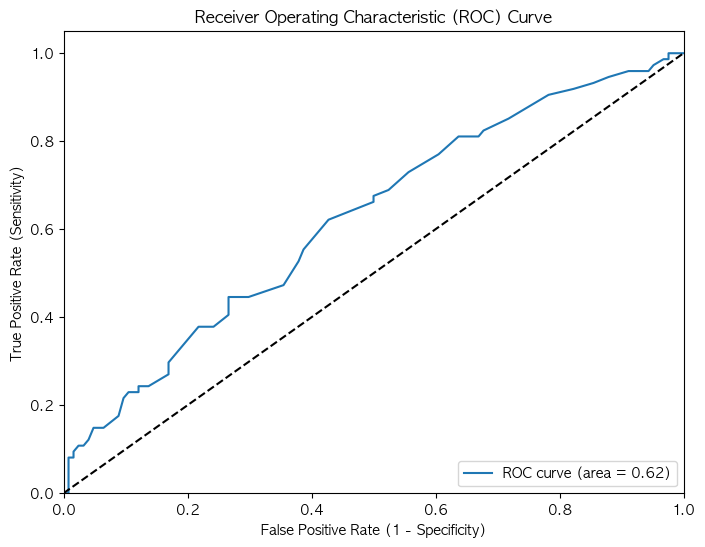

In [93]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 예측 확률을 얻는다 (로지스틱 회귀 예시)
y_pred_proba_1 = model.predict_proba(X_test)[:, 1]  # 클래스 1에 속할 확률만 사용

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_1)

# ROC AUC 계산
roc_auc = roc_auc_score(y_test, y_pred_proba_1)
print("ROC AUC:", roc_auc)

# ROC 곡선 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 대각선 직선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## drop columns

In [95]:
X_train.shape

(1187, 26)

In [98]:
mname='rf'
res_drop_cols = {'total' : ml.train(X_train, y_train, X_test, y_test, model_name=mname)}

for fea in tqdm(X_train.columns):
    res_drop_cols[fea] = ml.train(X_train.drop(columns=[fea]), y_train, X_test.drop(columns=[fea]), y_test, model_name=mname)

100%|██████████| 26/26 [00:36<00:00,  1.42s/it]


In [99]:
res_drop_cols.keys()

dict_keys(['total', '변동비대비매출액', '총자산회전율', '인건비대비매출액', '매출액', '매출채권 및 기타유동채권', '순운전자본(민식)', '매출채권', '변동비', '총비용', '비유동장기적합률', '고정비', '미처분이익잉여금(결손금)', '유동자산', '비유동비율', '자기자본비율', '비유동부채비율', '당좌비율', '급여', '영업손익', '자본금회전율', '연구개발비', 'manuf_GB', '유형자산', '비유동자산', '자본', '배당금지급(-)'])

In [100]:
res_drop_cols['total']

{'name': 'rf',
 'model': RandomForestClassifier(random_state=42),
 'results': {'cf_matrix': array([[109,  15],
         [ 50,  24]]),
  'accuracy': 0.6717171717171717,
  'precision': 0.6153846153846154,
  'recall': 0.32432432432432434,
  'f1': 0.4247787610619469,
  'roc_auc': 0.6967088055797733},
 'cv':                cf_matrix  accuracy  precision  recall     f1  roc_auc
 0  [[128, 28], [49, 33]]    0.6765     0.5410  0.4024 0.4615   0.6208
 1  [[127, 29], [63, 19]]    0.6134     0.3958  0.2317 0.2923   0.6024
 2  [[137, 19], [63, 18]]    0.6540     0.4865  0.2222 0.3051   0.6578
 3  [[129, 26], [57, 25]]    0.6498     0.4902  0.3049 0.3759   0.6315
 4   [[149, 6], [70, 12]]    0.6793     0.6667  0.1463 0.2400   0.6490}

In [101]:
res_drop_cols['total']['results']

{'cf_matrix': array([[109,  15],
        [ 50,  24]]),
 'accuracy': 0.6717171717171717,
 'precision': 0.6153846153846154,
 'recall': 0.32432432432432434,
 'f1': 0.4247787610619469,
 'roc_auc': 0.6967088055797733}

In [102]:
results, results_cv = [], []

for key in res_drop_cols.keys():
    res_drop_cols[key]['results']['name'] = key
    results.append(res_drop_cols[key]['results'])

    res_cv = dict(res_drop_cols[key]['cv'].drop(columns='cf_matrix').mean())
    res_cv['name'] = key
    results_cv.append(res_cv)

results = pd.DataFrame(results)
results_cv = pd.DataFrame(results_cv)

In [106]:
# test
results.sort_values('precision').head()

,cf_matrix,accuracy,precision,recall,f1,roc_auc,name
6,"[[103, 21], [59, 15]]",0.5960,0.4167,0.2027,0.2727,0.6575,순운전자본(민식)
11,"[[105, 19], [59, 15]]",0.6061,0.4412,0.2027,0.2778,0.6568,고정비
7,"[[104, 20], [58, 16]]",0.6061,0.4444,0.2162,0.2909,0.6556,매출채권
23,"[[104, 20], [56, 18]]",0.6162,0.4737,0.2432,0.3214,0.6507,유형자산
10,"[[106, 18], [57, 17]]",0.6212,0.4857,0.2297,0.3119,0.6818,비유동장기적합률


In [107]:
# test
results.sort_values('precision').tail()

,cf_matrix,accuracy,precision,recall,f1,roc_auc,name
17,"[[106, 18], [50, 24]]",0.6566,0.5714,0.3243,0.4138,0.6904,당좌비율
21,"[[109, 15], [54, 20]]",0.6515,0.5714,0.2703,0.3670,0.6724,연구개발비
16,"[[108, 16], [52, 22]]",0.6566,0.5789,0.2973,0.3929,0.6861,비유동부채비율
19,"[[108, 16], [51, 23]]",0.6616,0.5897,0.3108,0.4071,0.6919,영업손익
0,"[[109, 15], [50, 24]]",0.6717,0.6154,0.3243,0.4248,0.6967,total


In [108]:
# 교차검증
results_cv.sort_values('precision').head()

,accuracy,precision,recall,f1,roc_auc,name
20,0.6454,0.4890,0.2737,0.3395,0.6344,자본금회전율
8,0.6454,0.4912,0.2492,0.3218,0.6406,변동비
9,0.6454,0.4965,0.2444,0.3172,0.6340,총비용
13,0.6471,0.4969,0.2688,0.3404,0.6412,유동자산
18,0.6454,0.4974,0.2640,0.3332,0.6495,급여


In [109]:
# 교차검증
results_cv.sort_values('precision').tail()

,accuracy,precision,recall,f1,roc_auc,name
11,0.6588,0.5319,0.2689,0.3464,0.6472,고정비
2,0.6614,0.5380,0.2762,0.3543,0.6468,총자산회전율
5,0.6673,0.5431,0.2885,0.3706,0.6397,매출채권 및 기타유동채권
26,0.6664,0.5505,0.2786,0.3594,0.6528,배당금지급(-)
7,0.6639,0.5526,0.2689,0.3530,0.6462,매출채권


In [110]:
results_cv = results_cv.set_index('name')
results_cv

,accuracy,precision,recall,f1,roc_auc
name,,,,,
total,0.6546,0.5160,0.2615,0.3350,0.6323
변동비대비매출액,0.6521,0.5064,0.2469,0.3260,0.6360
총자산회전율,0.6614,0.5380,0.2762,0.3543,0.6468
인건비대비매출액,0.6479,0.4994,0.2664,0.3389,0.6387
매출액,0.6529,0.5066,0.2688,0.3435,0.6336
매출채권 및 기타유동채권,0.6673,0.5431,0.2885,0.3706,0.6397
순운전자본(민식),0.6563,0.5245,0.2835,0.3553,0.6409
매출채권,0.6639,0.5526,0.2689,0.3530,0.6462
변동비,0.6454,0.4912,0.2492,0.3218,0.6406


In [111]:
prec_total = results_cv.loc['total', 'precision']
prec_total

0.5160332342950472

In [113]:
results_cv[results_cv['precision']>=prec_total].sort_values('precision', ascending=False)

,accuracy,precision,recall,f1,roc_auc
name,,,,,
매출채권,0.6639,0.5526,0.2689,0.3530,0.6462
배당금지급(-),0.6664,0.5505,0.2786,0.3594,0.6528
매출채권 및 기타유동채권,0.6673,0.5431,0.2885,0.3706,0.6397
총자산회전율,0.6614,0.5380,0.2762,0.3543,0.6468
고정비,0.6588,0.5319,0.2689,0.3464,0.6472
자기자본비율,0.6614,0.5296,0.2762,0.3557,0.6391
순운전자본(민식),0.6563,0.5245,0.2835,0.3553,0.6409
비유동부채비율,0.6513,0.5216,0.2567,0.3362,0.6393
연구개발비,0.6546,0.5211,0.2689,0.3457,0.6342
